# Homework 2 - balancing & binning (deadline 28. 11. 2020)

In short, the main task is to play with balancing and binning to obtain the best results for the binary classification task.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can!

## What are you supposed to do:

  1. Download the dataset [here](https://www.dropbox.com/s/aq08ytozfplb97b/data.csv?dl=0).
  1. Use 2 binning methods (on features of your choice, with your choice of parameters) and comment on its effects on classification performance.
  1. Use at least 2 other data balancing techniques of your choice on the dataset and comment the classification results. **Just copied code from tutorial 4 will not be accepted.**
  1. Run all classification tests at least three times - once for unbalanced original data, twice for balanced data (try at least 2 balancing techniques), compare those results (give a comment).
  
Give comments (!) on each step of your solution, with short explanations of your choices.

**If you do all this properly, you will obtain 16 points.** 

## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, she can (!) give you another chance to rework your homework and to obtain more points. However, this is not a given, so do your best! :)
  * English is not compulsory.
  
## Data description

* The dataset can be downloaded [here](https://www.dropbox.com/s/aq08ytozfplb97b/data.csv?dl=0).
* The data are devoted to the binary classification task, the aim is to predict the probability that a driver will initiate an auto insurance claim in the next year.
* Target feature is called 'y' and signifies whether or not a claim was filed for that policy holder.
* To fulfill the task one does not need to know the meaning of predictors.
* Predictors that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation.
* While using [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), control the shuffling of data by random_state parameter. Do not use shuffle=False, probably never (can cause systematic error).

# Here comes my code

### Libraries Imports

In [1]:
from collections import namedtuple

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks

from math import ceil, floor

import matplotlib.pyplot as plt

import numpy as np
from numpy import where # Otherwise ValueError: Input contains NaN, infinity or a value too large for dtype('float32')

import pandas as pd

import pickle

import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Constants - having them here protects me from using one abbreviation for multiple purposes
MV = "missing_values"
PM = "percentage_missing"
UV = "unique_values"
# Randomness
SEED = 42

### Data Class

- First I tried to be ok with named tuples for the train and test sets. Because the train and test sets (train and validation) should be treated separately I came up with this class.
- Train set and test sets are always treated separately, but It can be performed in single action, such as `drop_features` automatically drops the same features from train and test set.

In [110]:
class Data():
    """Class for easy train and test set storage and manipulation."""

    SEED = SEED
    TEST_SET_RATIO = 0.2 # VALIDATION_SET_RATIO = 0.2
    
    def __init__(self, *, name, train, test):
        self.name = name
        self.train = train
        self.test = test

    @classmethod
    def from_dataframe(cls, *, name, X, y, test_set_ratio=TEST_SET_RATIO, seed=SEED, drop_features=None):
        """Split given features and target variable with by the given test_set_ratio, and seed.
        It can automaticly drop features if `drop_features` specified.
        """
        
        X = X.drop(drop_features, axis=1) if (drop_features is not None) else X.copy()
        y = y.copy()
        
        train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=test_set_ratio, random_state=seed)
        
        return cls(name=name, train=Dataset(X=train_X, y=train_y), test=Dataset(X=test_X, y=test_y))


    def sample_train_set(self, *, name, train_size, test_set_ratio=TEST_SET_RATIO, seed=SEED):
        """Sample the train set into train and validation sets to match the train_size and test_set_ratio."""
        
        total_size = ceil(train_size / (1 - test_set_ratio))

        X = self.train.X.sample(n=total_size, random_state=seed)
        y = self.train.y.loc[X.index.values]
        
        return Data.from_dataframe(name=name, X=X, y=y, test_set_ratio=test_set_ratio, seed=seed)


    def copy(self, *, name=None, suffix="copy"):
        """Deep copy of a Data object. Dataframes are deeply copied that prevents mysterious data changes"""
        return Data(
            name =  f"{self.name}_{suffix}" if (name is None) else name,
            train = Dataset(X=self.train.X.copy(), y=self.train.y.copy()),
            test =  Dataset(X=self.test.X.copy(),  y=self.test.y.copy())
        )


    def __repr__(self):
        return " ".join(["<Data:", f"name={self.name},",
            f"train=(X.shape={self.train.X.shape}, y.shape={self.train.y.shape}),",
            f"test=(X.shape={self.test.X.shape}, y.shape={self.test.y.shape})>",
        ])


    def get_train_y_groups_sizes(self):
        """Return list of tuples, where at first position is the group class,
        and at the second position is the number of train samples that belong to the class.
        """

        value_counts = self.train.y.value_counts()
        return list(zip(value_counts.index.values, value_counts.values))


    def drop_features(self, features, name=None):
        """Drop given features from either train and test sets."""

        return Data(
            name  = self.name if (name is None) else name,
            train = Dataset(X=self.train.X.drop(features, axis=1), y=self.train.y),
            test  = Dataset(X=self.test.X.drop(features, axis=1, errors="ignore"),  y=self.test.y)
        )


In [4]:
# Prepared namedtuples for easier data manipulation

Dataset = namedtuple("Dataset", ["X", "y"])

Classifier = namedtuple("Classifier", ["name", "estimator"])

Model = namedtuple("Model", ["classifier", "data", "y_prediction"])

Evaluation = namedtuple("Evaluation", ["data_name", "model_name", "accuracy", "auc", "f1_score"])

Balancer = namedtuple("Balancer", ["name", "method"])

### Classifiers

- To be honest, I took all the classifiers that crossed my mind and tried their training times.
    - This four seems to be quick enough that I could get the results relatively soon.
- I tried to do as little hyperparameter tuning as possible, because the hyperparameters are always connected to the specific data I wanted them to be fixed and see the impacts of the binning and balancing only.
    - It also means, the final results could be better if the hyperparameters tuning would be performed.

In [5]:
CLASSIFIERS = (
    Classifier("decision_tree",         DecisionTreeClassifier(random_state=SEED)),
    Classifier("naive_bayes",           GaussianNB()),
    Classifier("logistic_regression",   LogisticRegression(max_iter=1000, random_state=SEED)),
    Classifier("multilayer_perceptron", MLPClassifier(alpha=1, max_iter=1000, random_state=SEED)),
)

### Data Cleansing Functions

In [6]:
def dropHalfEmptyColumns(data, max_missing_ratio = 0.10):
    """Get train features with higher percentage of missing values than max_missing_ratio parameter.
    Drop theses features from data.train.X and data.test.X"
    """

    df_tmp = data.train.X.apply(lambda x: (x == -1).sum())
    drop_features = df_tmp[df_tmp > data.train.X.shape[0]*max_missing_ratio].index
    
    return data.drop_features(drop_features)


def getCategoricalColumns(df):
    """Return columns that their name ends with "_cat" """
    return np.array([x for x in df.columns if x.endswith("_cat")])


def dropHighCardinalityCategoricalFeatures(data, max_categorical_cardinality = 10):
    """Drop categorical features with too high cardinality.
    Parameter max_categorical_cardinality defines the maximum number of unique values per categorical feature.
    """
    cat_cols = getCategoricalColumns(data.train.X)

    drop_cols = cat_cols[data.train.X[cat_cols].nunique() >= max_categorical_cardinality]

    return data.drop_features(drop_cols)  


def getEncodedCategoricalColumns(suffix, df):
    """Return columns with given suffix"""
    return [x for x in df.columns if x.endswith(str(suffix))]


def convertCategoricalFeatures(data):
    """Convert given columns to types to categorical type.
    Show types of categorical columns. Also show types of non-categorical features.
    """
    cols = getCategoricalColumns(data.train.X)
    data.train.X[cols] = data.train.X[cols].astype("category")
    data.test.X[cols] =  data.test.X[cols].astype("category")
    
    print(f"Train - categorical columns types: {list({type(x) for x in data.train.X[cols].dtypes})}",
        f"Train - other columns types:       {data.train.X.drop(cols, axis=1).dtypes.unique()}\n", 
        f"Test - categorical columns types: {list({type(x) for x in data.test.X[cols].dtypes})}",
        f"Test - other columns types:       {data.test.X.drop(cols, axis=1).dtypes.unique()}\n", 
    sep="\n")
    return data


def oneHotEncoding(data):
    """For categorical features perform one-hot encoding.
    Add the encoded features to given dataframe and drop the original (not-encoded) columns.
    """
    features = data.train.X.dtypes[data.train.X.dtypes == "category"].index.values
    if features.size == 0: return data # No Categorical Features to Dummify
    
    train_X = pd.concat([
        data.train.X.drop(features, axis=1), 
        pd.get_dummies(data.train.X[features])
    ], axis=1)
    test_X = pd.concat([
        data.test.X.drop(features, axis=1), 
        pd.get_dummies(data.test.X[features])
    ], axis=1)
    
    add = train_X.columns.difference(test_X.columns) # Missing in test, needs to be added to test
    test_X[add] = 0
    drop = test_X.columns.difference(train_X.columns) # Missing in train, needs to be dropped from test
    test_X = test_X.drop(drop, axis=1)

    return Data(name=data.name, train=Dataset(X=train_X, y=data.train.y), test=Dataset(X=test_X, y=data.test.y))


def dropMissingValuesEncodedToFeatures(data):
    """Drop features representing missing values. Created by one-hot encoding"""

    drop_features = getEncodedCategoricalColumns("-1", data.train.X)
    return data.drop_features(drop_features)

### Plotting Functions Wrappers

In [7]:
def showBarplotWithPercentages(x, y, df, total=None, title=f""):
    """Show barplot with bars in descending order and percentages on top"""

    df = df.sort_values(by=y, ascending=False)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.barplot(x=x, y=y, data=df, ax=ax, palette="muted")

    for p in ax.patches:
        if total is not None:
            annotation = '{:.1f}%'.format((p.get_height()/total) * 100) # percentage
        else:
            annotation = p.get_height()
        x = p.get_x() + p.get_width()/10
        y = int((p.get_y() + p.get_height()*1.005))
        ax.annotate(annotation, (x, y))

    ax.set_title(title)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
    return ax


def showHistogramAndBoxplot(feature, df, discrete):
    """Show histogram and boxplot for given dataframe feature"""

    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(16, 6)
    sns.histplot(x=feature, data=df, discrete=discrete, ax=axes[0]).set_title(f"Histogram of {feature} feature")
    sns.boxplot(x=feature, data=df, ax=axes[1]).set_title(f"{feature} feature boxplot")

### Exploration Functions

In [8]:
def showCategories(df, x="feature", y= UV):
    """Show barplot with sizes of categorical features"""

    cat_cols = getCategoricalColumns(df)
    data = df[cat_cols].nunique().reset_index().rename(columns={"index": x, 0: y})
    
    ax = showBarplotWithPercentages(x=x, y=y, df=data, total=None,
        title="Numbers of categorical features unique values")
    return ax


def showMissingValues(df, x="feature", y=MV):
    """Show barplot number of missing values per features"""

    data = df.apply(lambda x: (x == -1).sum()).reset_index().rename(columns={"index": x, 0: y})
    data = data[data[MV] > 0]

    ax = showBarplotWithPercentages(x=x, y=y, df=data, total=df.shape[0],
        title="Columns with missing values (-1) and percentages of missing values")
    return ax


def showCategoriesAndMissingValues(df, uv=UV, mv=MV, hue="feature"):
    """Show features scatter plot of unique and missing values"""

    cat_cols = getCategoricalColumns(df)
    
    data = pd.concat([
        df[cat_cols].nunique(),
        df[cat_cols].apply(lambda x: (x == -1).sum())
    ], axis=1).reset_index().rename(columns={"index": hue, 0: uv, 1: mv})

    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.scatterplot(x=uv, y=mv, hue=hue, data=data,s=500, palette="deep", ax=ax)
    _ = ax.set_title("Dependency of unique values number on missing values number (categorical cols)")
    return ax


def showSizesOfFeatureCategories(feature, df):
    """For given feature show size of its each category"""

    df[feature] # Test for key presence
    fig, ax = plt.subplots(figsize=(16, 10))
    ax = sns.countplot(x=feature, data=df, ax=ax)
    ax.set_title(f"\"{feature}\" categories sizes")
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
    return ax

### Binning

In [9]:
def discretizeFeature(feature, data, equal, interval_method):
    """Discretize feature into categories, either with fixed interval size, or with fixed number of samples"""

    interval_num = ceil(interval_method(data.train.X[feature].nunique()))
    print(f"Number of Intervals: {interval_num}")

    bin_labels = list(range(interval_num))
    bin_feature = f"{feature}_{equal}_{interval_num}"
    print(f"Name of binned feature: {bin_feature}")
    
    bin_method = pd.qcut if equal == "depth" else pd.cut
    
    data.train.X[bin_feature] = bin_method(data.train.X[feature], interval_num, labels=bin_labels).cat.codes
    data.test.X[bin_feature] =  bin_method(data.test.X[feature], interval_num, labels=bin_labels).cat.codes
    
    return bin_feature

### Model Training and Evaluation Functions 

In [11]:
def trainModel(classifier, data):
    print(f"\n[{classifier.name}] {data.name}")
    y_prediction =  classifier.estimator.fit(data.train.X, data.train.y).predict(data.test.X)
    return Model(classifier=classifier, data=data, y_prediction=y_prediction)

def evaluateModel(model):
    """Evaluate model with accuracy, auc and f1 scores and return Evaluation namedtuple"""
    ev = Evaluation(data_name=model.data.name, model_name=model.classifier.name,
        accuracy=accuracy_score(model.data.test.y, model.y_prediction),
        auc=roc_auc_score(model.data.test.y, model.y_prediction),
        f1_score=f1_score(model.data.test.y, model.y_prediction)
    )
    print(f"{f'[{ev.model_name}]': <24} {ev.data_name: <24} Acc: {ev.accuracy:.5f}\tAUC: {ev.auc:.5f}\tF1: {ev.f1_score:.5f}")
    return ev

def showEvaluations(evals):
    """Show 2D grid of barplots, where x axis covers different scores and y covers different classifiers"""

    eval_df = pd.DataFrame(evals)
    df = eval_df

    df = pd.melt(df, id_vars=["data_name", "model_name"], 
        value_name="score_value").rename(columns={'variable':"score", "model_name":"model"})

    g = sns.FacetGrid(df, col="score", row="model", hue="score", sharex=False, height=2.4, aspect=1.8)
    _ = g.map(sns.barplot, "score_value", "data_name", order=None)

    for axes in g.axes:
        for ax in axes:
            for p in ax.patches:
                annotation = f"{p.get_width():.5}"
                x = (p.get_x() + p.get_width()/4)
                y = (p.get_y() + (p.get_height()/4)*3)
                ax.annotate(annotation, (x, y))    
    return g


## 1) Download the dataset

In [12]:
# Load the Dataframe
original_df = pd.read_csv('data.csv')

print(f"Shape of the original dataframe: {original_df.shape}")

Shape of the original dataframe: (595212, 58)


In [13]:
# Basic information about the loaded dataframe
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 58 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   y             595212 non-null  int64  
 1   xind_01       595212 non-null  int64  
 2   xind_02_cat   595212 non-null  int64  
 3   xind_03       595212 non-null  int64  
 4   xind_04_cat   595212 non-null  int64  
 5   xind_05_cat   595212 non-null  int64  
 6   xind_06_bin   595212 non-null  int64  
 7   xind_07_bin   595212 non-null  int64  
 8   xind_08_bin   595212 non-null  int64  
 9   xind_09_bin   595212 non-null  int64  
 10  xind_10_bin   595212 non-null  int64  
 11  xind_11_bin   595212 non-null  int64  
 12  xind_12_bin   595212 non-null  int64  
 13  xind_13_bin   595212 non-null  int64  
 14  xind_14       595212 non-null  int64  
 15  xind_15       595212 non-null  int64  
 16  xind_16_bin   595212 non-null  int64  
 17  xind_17_bin   595212 non-null  int64  
 18  xind

### Check if we can identify rows just by the index

In [14]:
print(f"Can we access rows just by specifying index?: {original_df.index.is_unique}")

Can we access rows just by specifying index?: True


### Split the Dataframe into Train and Test Sets

- Test set will stay untouched until the final valuation

In [15]:
original = Data.from_dataframe(name="original", X=original_df.drop(["y"], axis=1), y=original_df.y)

print(f"Original data: {original}")

Original data: <Data: name=original, train=(X.shape=(476169, 57), y.shape=(476169,)), test=(X.shape=(119043, 57), y.shape=(119043,))>


### Sample the Train Set for Testing Purposes and Divide the Sample into Train and Validation Sets

- Appropriate procedures and parameters may be found on smaller subset of the training set.
- It is not neccessary to use full training set to find the best candidates (10% of the train set will be used).
    - Validation set (created from the sample) will be used to identify the best candidates.


In [16]:
train_size = ceil(original.train.X.shape[0]*0.10) # Ten percent of train samples

print(f"Desired train set size: {train_size}\n")

sample = original.sample_train_set(name="sample", train_size=train_size)

print(f"Sample: {sample}")

Desired train set size: 47617

Sample: <Data: name=sample, train=(X.shape=(47617, 57), y.shape=(47617,)), test=(X.shape=(11905, 57), y.shape=(11905,))>


### Look at the y values

- Is the task binary or multiclass classification?
- Are the classes balanced? (Do they have similar sizes?)

In [17]:
print(f"Number of samples for every y class (y, size):", *sample.get_train_y_groups_sizes(), sep="\n- ")

Number of samples for every y class (y, size):
- (0, 45893)
- (1, 1724)


## Data Cleansing

Some data cleansing is required for the classification to be correct.
- In order the classification to be correct, the categorical features will be converted to categorical type and encoded to binary values with one-hot encoding method.
- It prevents them from being compared in incomparable ways.

### Rules of Thumb

- During the data exploration some additional cleansing would look that good that i had to try it.
- There is no guarantee of such a cleansing approaches, at the end the basic cleansing and the thumb cleansing are compared.

### Make Copy of the Train and Validations Sets for Further Cleansing

- Rules of Thumb applied to one copy of the train and test sets of the sample of the main train set

In [18]:
sample_thumb = sample.copy(suffix="thumb")

print(f"Feature dataframes are still the same? {id(sample_thumb.train.X) == id(sample.train.X)}")

Feature dataframes are still the same? False


### Explore Missing Values

The missing values are encoded with value `-1` so it is not visible at first glance how much values there are missing.

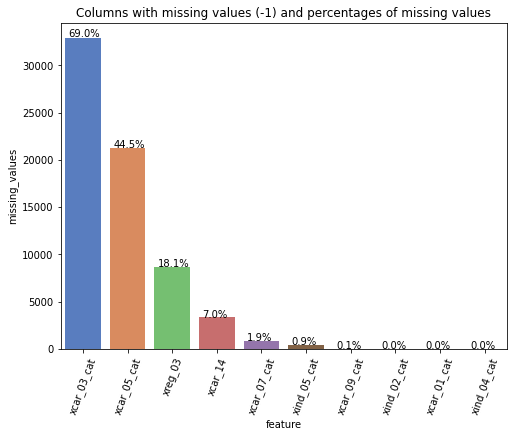

In [19]:
_ = showMissingValues(sample.train.X)

- The missing values should be treated separatedly.
    - Perhaps some imputation method should be used so the missing values would make sense.
    - Usually good choice is the k-Nearest Neighbors, however even the replacment with mean works better than just leaving there an artificial number.

- It does not need to be true, if the values are missing from some systematical reason, the reason can be explored.
    - For this analysis I will hope, the values are missing for a good reason, so I won't impute them anyhow.

### Drop columns with too many missing values

- As a rule of thumb features with missing more than 10% values will be dropped. 

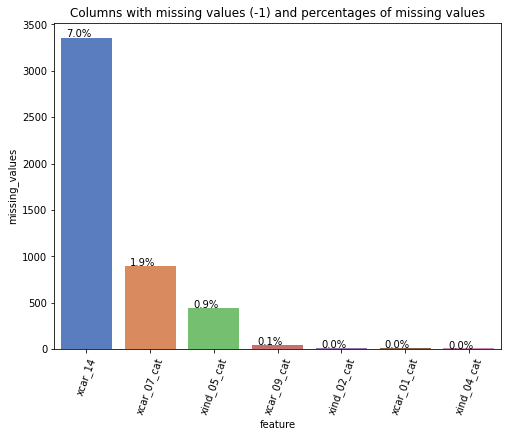

In [20]:
sample_thumb = dropHalfEmptyColumns(sample_thumb)

_ = showMissingValues(sample_thumb.train.X)

### Cardinality of Categorical Features

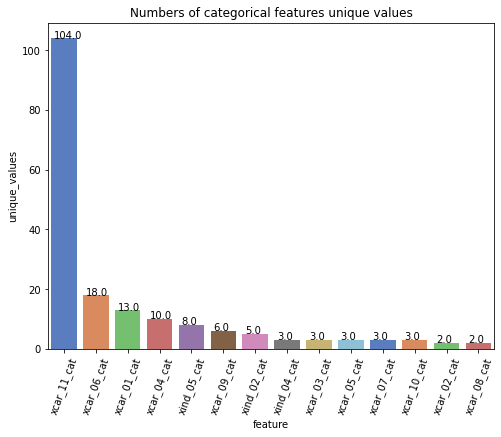

In [21]:
_ = showCategories(sample.train.X)

### Drop categorical columns with too many categories

- All the categorical features will be one-hot encoded, it means the more unique values the more features in the final train and test sets.
- As another rule of thumb, (because the curse of dimensionality) categorical features with more than 10 unique values will be dropped. 

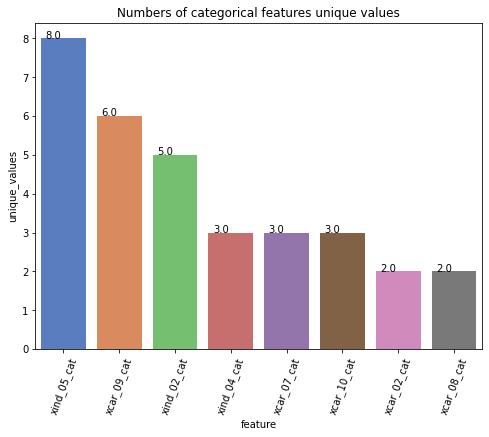

In [22]:
sample_thumb = dropHighCardinalityCategoricalFeatures(sample_thumb)

_ = showCategories(sample_thumb.train.X)

### Convert Categorical Features to Categorical Type

In [23]:
print(f"\n{' Sampled Train Set '.center(79, '-')}\n")
sample = convertCategoricalFeatures(sample)

print(f"\n{' Sampled Train Set (thumb rules) '.center(79, '-')}\n")
sample_thumb = convertCategoricalFeatures(sample_thumb)


------------------------------ Sampled Train Set ------------------------------

Train - categorical columns types: [<class 'pandas.core.dtypes.dtypes.CategoricalDtype'>]
Train - other columns types:       [dtype('int64') dtype('float64')]

Test - categorical columns types: [<class 'pandas.core.dtypes.dtypes.CategoricalDtype'>]
Test - other columns types:       [dtype('int64') dtype('float64')]


----------------------- Sampled Train Set (thumb rules) -----------------------

Train - categorical columns types: [<class 'pandas.core.dtypes.dtypes.CategoricalDtype'>]
Train - other columns types:       [dtype('int64') dtype('float64')]

Test - categorical columns types: [<class 'pandas.core.dtypes.dtypes.CategoricalDtype'>]
Test - other columns types:       [dtype('int64') dtype('float64')]



### Make Categorical Columns Suitable for Classifiers

- Check if One-Hot encoding is possible (i.e. check whether the cardinality is not to high)

**Some columns has high cardinality let's look how much values are they miss**

- In case there would be significant percentage of missing values we could drop them with peace in mind


------------------------------ Sampled Train Set ------------------------------



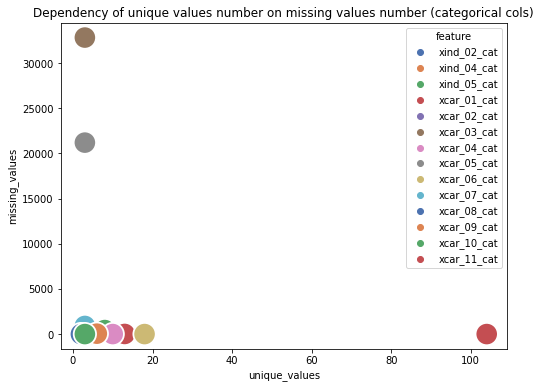

In [24]:
print(f"\n{' Sampled Train Set '.center(79, '-')}\n")
_ = showCategoriesAndMissingValues(sample.train.X)


----------------------- Sampled Train Set (thumb rules) -----------------------



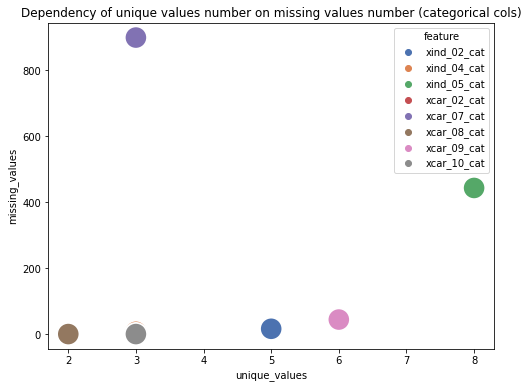

In [25]:
print(f"\n{' Sampled Train Set (thumb rules) '.center(79, '-')}\n")
_ = showCategoriesAndMissingValues(sample_thumb.train.X)

- The thumb sample looks good to me, I see no need to drop more features.

### Explore the categories sizes of categorical features

- Optional further categorical features exploration.
- It may be better to drop feature, that has most of its values only of one category.


Categorical columns: ['xind_02_cat' 'xind_04_cat' 'xind_05_cat' 'xcar_01_cat' 'xcar_02_cat'
 'xcar_03_cat' 'xcar_04_cat' 'xcar_05_cat' 'xcar_06_cat' 'xcar_07_cat'
 'xcar_08_cat' 'xcar_09_cat' 'xcar_10_cat' 'xcar_11_cat']



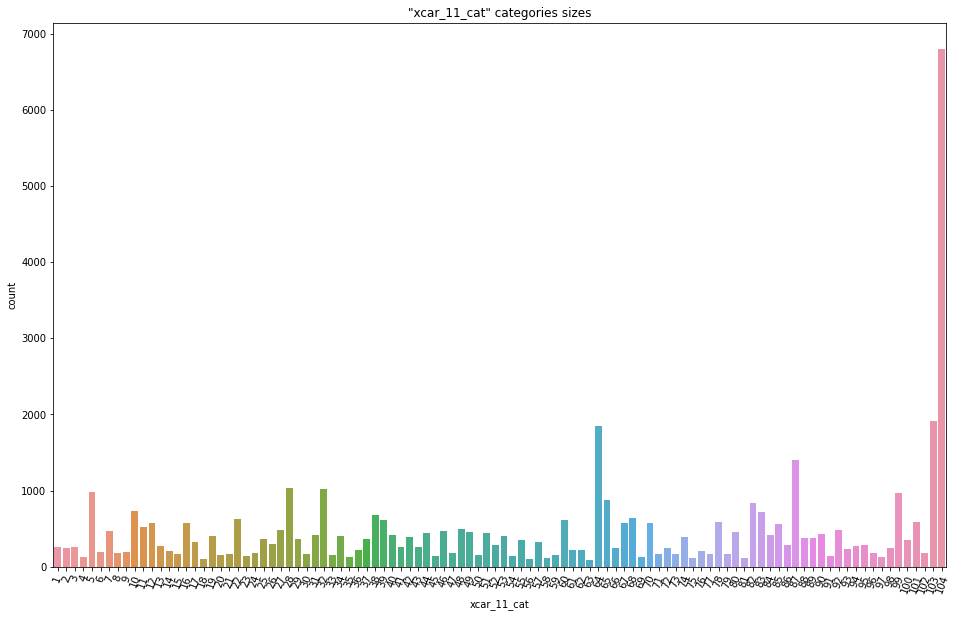

In [26]:
print(f"Categorical columns: {getCategoricalColumns(sample.train.X)}\n")

_ = showSizesOfFeatureCategories('xcar_11_cat', sample.train.X) # CHOOSE FEATURE - It is easy to copy from below

- It looks fine, further feature engineering are not the topic of this homework.

### One-hot Encoding

- Concatenate non-categorical columns with the one-hot encoding of the categorical colums separately for train and test features.
- Because the train and test sets may have different values -> different encoded features, the test sets are treated to match the train set.
    - Features from train set that miss in test set are added (to the test set)
    - Features that are in the test set but miss in train set are dropped (from the test set)

In [27]:
print(f"\n{' Sampled Train Set '.center(79, '-')}\n")
print(f"BEFORE: {sample}")
sample = oneHotEncoding(sample)
print(f"AFTER:  {sample}")

print(f"\n{' Sampled Train Set (rules of thumb) '.center(79, '-')}\n")
print(f"BEFORE: {sample_thumb}")
sample_thumb = oneHotEncoding(sample_thumb)
print(f"AFTER:  {sample_thumb}")


------------------------------ Sampled Train Set ------------------------------

BEFORE: <Data: name=sample, train=(X.shape=(47617, 57), y.shape=(47617,)), test=(X.shape=(11905, 57), y.shape=(11905,))>
AFTER:  <Data: name=sample, train=(X.shape=(47617, 226), y.shape=(47617,)), test=(X.shape=(11905, 226), y.shape=(11905,))>

---------------------- Sampled Train Set (rules of thumb) ---------------------

BEFORE: <Data: name=sample_thumb, train=(X.shape=(47617, 50), y.shape=(47617,)), test=(X.shape=(11905, 50), y.shape=(11905,))>
AFTER:  <Data: name=sample_thumb, train=(X.shape=(47617, 74), y.shape=(47617,)), test=(X.shape=(11905, 74), y.shape=(11905,))>


### Show Features Representing Missing Values

In [28]:
print("[sample] Encoded columns that represents missing values:",
    *getEncodedCategoricalColumns("-1", sample.train.X),
sep="\n")

[sample] Encoded columns that represents missing values:
xind_02_cat_-1
xind_04_cat_-1
xind_05_cat_-1
xcar_01_cat_-1
xcar_03_cat_-1
xcar_05_cat_-1
xcar_07_cat_-1
xcar_09_cat_-1


### Drop columns representing missing values

I chose to drop the columns representing missing values.
- Certainly there are better ways to handle this problem such as imputation methods or at least start with proper exploration of any dependencies before such an action. 

In [29]:
sample_thumb = dropMissingValuesEncodedToFeatures(sample_thumb)

print("[sample_thumb] Encoded columns that represents missing values:",
    *getEncodedCategoricalColumns("-1", sample_thumb.train.X),
sep="\n")

[sample_thumb] Encoded columns that represents missing values:


### Dataframe Shape After Cleansing

In [30]:
print(f"\n{' Sampled Train Set '.center(79, '-')}\n", sample, sep="\n", end="\n")
print(f"Number of samples for every y class (y, size):", *sample.get_train_y_groups_sizes(), sep="\n- ")

print(f"\n{' Sampled Train Set (rules of thumb) '.center(79, '-')}\n", sample_thumb, sep="\n", end="\n")
print(f"Number of samples for every y class (y, size):", *sample_thumb.get_train_y_groups_sizes(), sep="\n- ")


------------------------------ Sampled Train Set ------------------------------

<Data: name=sample, train=(X.shape=(47617, 226), y.shape=(47617,)), test=(X.shape=(11905, 226), y.shape=(11905,))>
Number of samples for every y class (y, size):
- (0, 45893)
- (1, 1724)

---------------------- Sampled Train Set (rules of thumb) ---------------------

<Data: name=sample_thumb, train=(X.shape=(47617, 69), y.shape=(47617,)), test=(X.shape=(11905, 69), y.shape=(11905,))>
Number of samples for every y class (y, size):
- (0, 45893)
- (1, 1724)


### Compare Thumb Rules with Minimum Cleansing Approach

- The main motivation is to shorten the execution time without model quality loss
    - The original dataframe after one-hot encoding has about 226 features (working with the 10% sample so when the SEED would be changed, the number may differ)
    - It causes most of the algorithms to be slow (not mentioning the dimensionality curse).
- If the thumb sample will have similar predictions to the basic cleansed sample, then the thumb sample will be used.

### Train the Classifiers

In [31]:
%%time

cleansing_models = []

for classifier in CLASSIFIERS:
    print("\n", f" {classifier.name} ".center(79, "-"))
    
    for data in (sample, sample_thumb):
        %time cleansing_models.append(trainModel(classifier, data))
    
del classifier, data; print(f"\n{' Total cell execution time '.center(79, '#')}\n")


 -------------------------------- decision_tree --------------------------------

[decision_tree] sample
CPU times: user 3.66 s, sys: 5.22 ms, total: 3.67 s
Wall time: 3.66 s

[decision_tree] sample_thumb
CPU times: user 1.01 s, sys: 0 ns, total: 1.01 s
Wall time: 1.01 s

 --------------------------------- naive_bayes ---------------------------------

[naive_bayes] sample
CPU times: user 148 ms, sys: 31 ms, total: 179 ms
Wall time: 178 ms

[naive_bayes] sample_thumb
CPU times: user 58.4 ms, sys: 3.19 ms, total: 61.6 ms
Wall time: 60.7 ms

 ----------------------------- logistic_regression -----------------------------

[logistic_regression] sample


/home/langerjaros/.langerenv_0.2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 2min 17s, sys: 1min 15s, total: 3min 32s
Wall time: 27.5 s

[logistic_regression] sample_thumb
CPU times: user 1min 23s, sys: 1min 9s, total: 2min 32s
Wall time: 19.2 s

 ---------------------------- multilayer_perceptron ----------------------------

[multilayer_perceptron] sample
CPU times: user 1min 41s, sys: 2min 29s, total: 4min 10s
Wall time: 42min 24s

[multilayer_perceptron] sample_thumb
CPU times: user 1min 35s, sys: 2min 30s, total: 4min 5s
Wall time: 32.6 s

########################## Total cell execution time ##########################

CPU times: user 7min 1s, sys: 7min 25s, total: 14min 27s
Wall time: 43min 48s


### Evaluate the Cleansing and Visualize the Results

In [32]:
cleansing_evals = []
        
for model in cleansing_models:
    cleansing_evals.append(evaluateModel(model))

[decision_tree]          sample                   Acc: 0.92281	AUC: 0.51445	F1: 0.06701
[decision_tree]          sample_thumb             Acc: 0.91718	AUC: 0.50209	F1: 0.04642
[naive_bayes]            sample                   Acc: 0.47862	AUC: 0.54652	F1: 0.08384
[naive_bayes]            sample_thumb             Acc: 0.49265	AUC: 0.56849	F1: 0.08981
[logistic_regression]    sample                   Acc: 0.96153	AUC: 0.50000	F1: 0.00000
[logistic_regression]    sample_thumb             Acc: 0.96153	AUC: 0.50000	F1: 0.00000
[multilayer_perceptron]  sample                   Acc: 0.96153	AUC: 0.50000	F1: 0.00000
[multilayer_perceptron]  sample_thumb             Acc: 0.96153	AUC: 0.50000	F1: 0.00000


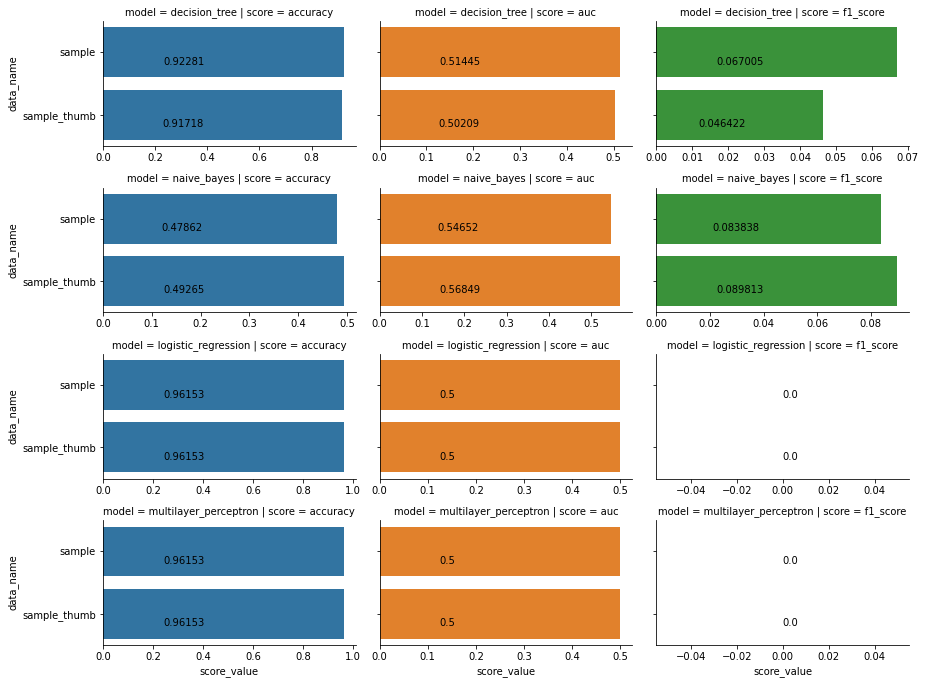

In [33]:
_ = showEvaluations(cleansing_evals)

### Cleansing Conclusion

- The Thumb rules look kind of neutral to the model scores.
- Because it will be much nicer to work with dataframe with 69 features and not with 226 features both the binning and balancing will be tested with this "thumb rule sample" data.
- I take the risk, that these cleansing steps were harmful and that it can later cause some prediction quality loss. However based on these results I hope the potential for such a loss is not very big.

## Binning

The binning is tested with the 10% sample of the train set, that were cleansed with the thumb rules.

In [34]:
binning = sample_thumb.copy(name="binning")

#### Show the Features with Highest Cardinality

I chosed to discretize the highest cardinality feature i.e. the fature with the biggest number of unique values.

In [35]:
binning.train.X.nunique().sort_values(ascending=False)[:5]

xcar_13     21239
xcar_14       697
xcar_12       113
xcalc_14       23
xcalc_10       23
dtype: int64

I chosed to perform binning on "xcar_13" feature, because it has the highest number of unique values.
- If desired, the only thing that needs to be changed is the `binning_feature` value

In [36]:
binning_feature = "xcar_13"

binned_features = []

### Histogram of xcar_13 (values distribution)

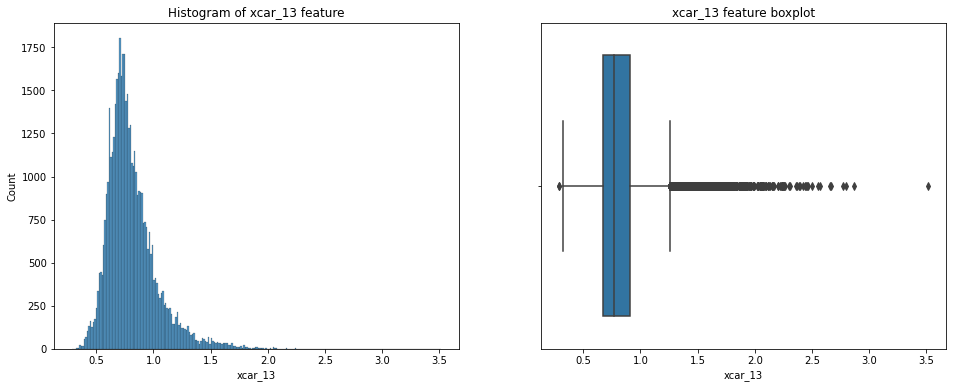

In [37]:
binned_feature = binning_feature

showHistogramAndBoxplot(binned_feature, binning.train.X, discrete=None)

binned_features.append(binned_feature)

## Binning Principle

- The feature is separatly binned in the train and test sets.
- The binned feature is added to the dataframes of the train and test sets with name describing the method "width" / "depth" and the bins number (e.g. my_feature_width_5).
- Right before the training of the classifiers the train and test sets (with only one version of the binning feature) are created.

#### Number of Bins

- As a rule of thumb i chosed to try to apply the following fuctions to the number of unique values of the feature, functions: log10, log2, cube root and square.

### Equal Width Binning

Number of Intervals: 5
Name of binned feature: xcar_13_width_5


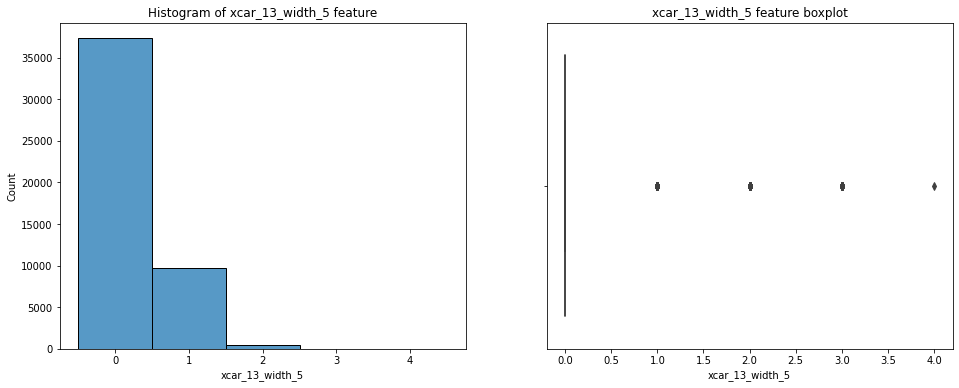

In [38]:
binned_feature = discretizeFeature(binning_feature, binning, equal="width", interval_method=np.log10)

showHistogramAndBoxplot(binned_feature, binning.train.X, discrete=True)

binned_features.append(binned_feature)

Number of Intervals: 15
Name of binned feature: xcar_13_width_15


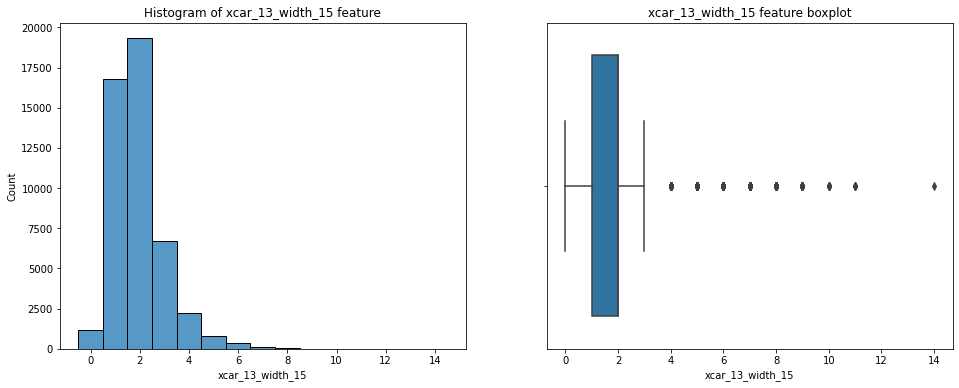

In [39]:
binned_feature = discretizeFeature(binning_feature, binning, equal="width", interval_method=np.log2)

showHistogramAndBoxplot(binned_feature, binning.train.X, discrete=True)

binned_features.append(binned_feature)

Number of Intervals: 28
Name of binned feature: xcar_13_width_28


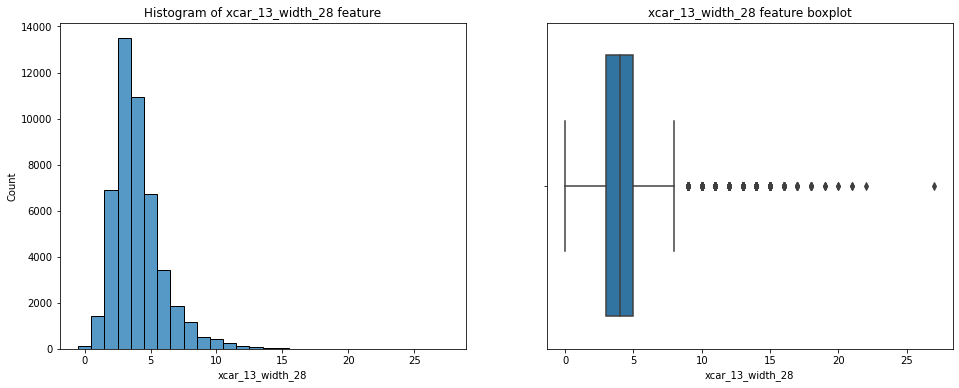

In [40]:
binned_feature = discretizeFeature(binning_feature, binning, equal="width", interval_method=np.cbrt)

showHistogramAndBoxplot(binned_feature, binning.train.X, discrete=True)

binned_features.append(binned_feature)

Number of Intervals: 146
Name of binned feature: xcar_13_width_146


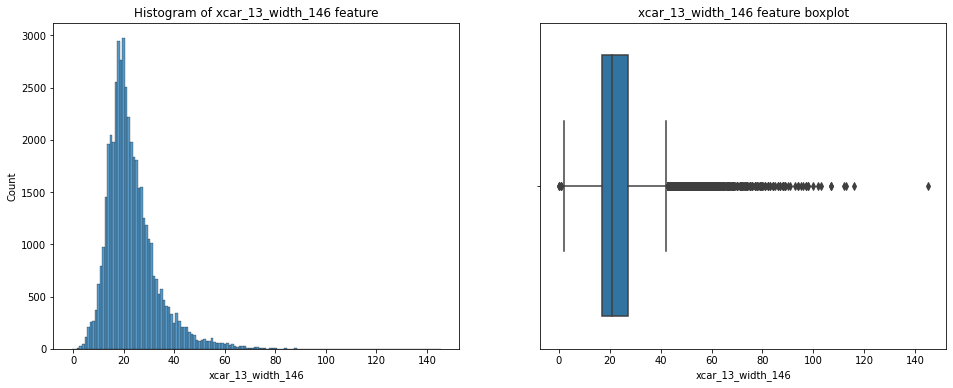

In [41]:
binned_feature = discretizeFeature(binning_feature, binning, equal="width", interval_method=np.sqrt)

showHistogramAndBoxplot(binned_feature, binning.train.X, discrete=True)

binned_features.append(binned_feature)

### Equal Depth Binning

Number of Intervals: 5
Name of binned feature: xcar_13_depth_5


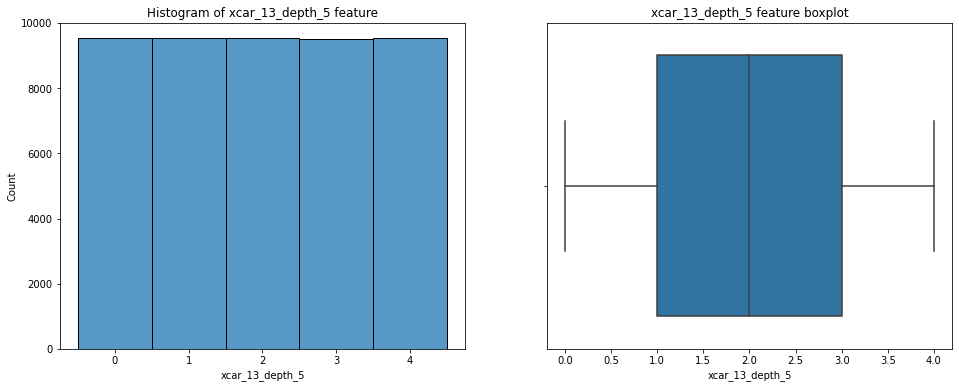

In [42]:
binned_feature = discretizeFeature(binning_feature, binning, equal="depth", interval_method=np.log10)

showHistogramAndBoxplot(binned_feature, binning.train.X, discrete=True)

binned_features.append(binned_feature)

Number of Intervals: 15
Name of binned feature: xcar_13_depth_15


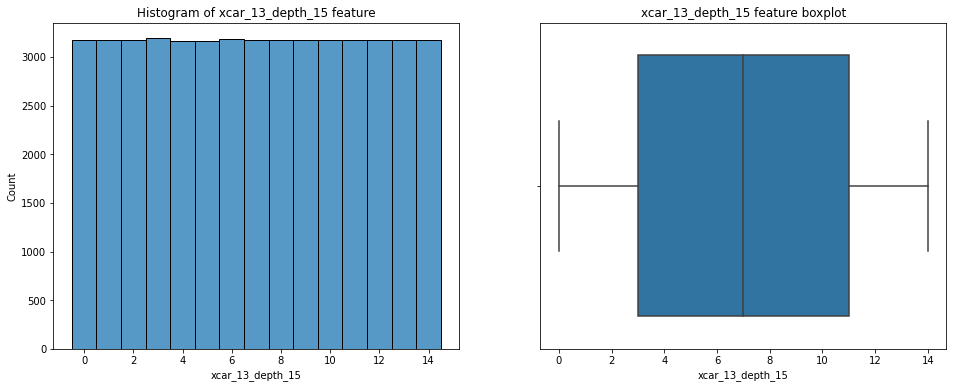

In [43]:
binned_feature = discretizeFeature(binning_feature, binning, equal="depth", interval_method=np.log2)

showHistogramAndBoxplot(binned_feature, binning.train.X, discrete=True)

binned_features.append(binned_feature)

Number of Intervals: 28
Name of binned feature: xcar_13_depth_28


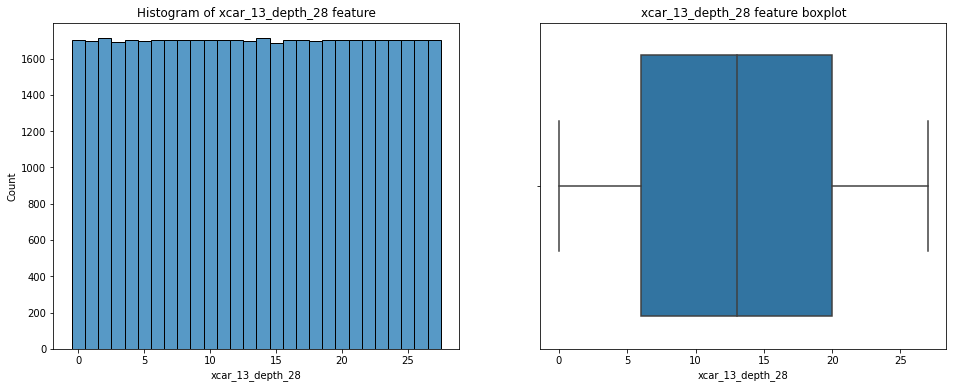

In [44]:
binned_feature = discretizeFeature(binning_feature, binning, equal="depth", interval_method=np.cbrt)

showHistogramAndBoxplot(binned_feature, binning.train.X, discrete=True)

binned_features.append(binned_feature)

Number of Intervals: 146
Name of binned feature: xcar_13_depth_146


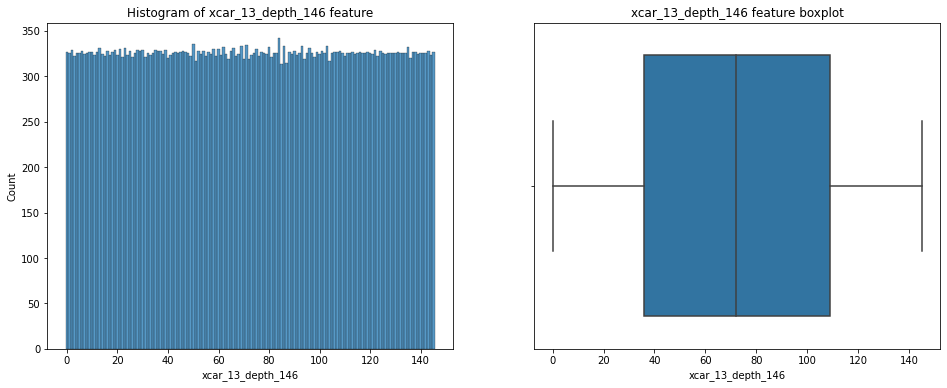

In [45]:
binned_feature = discretizeFeature(binning_feature, binning, equal="depth", interval_method=np.sqrt)

showHistogramAndBoxplot(binned_feature, binning.train.X, discrete=True)

binned_features.append(binned_feature)

In [46]:
print(f"List of binned features: {binned_features}")

List of binned features: ['xcar_13', 'xcar_13_width_5', 'xcar_13_width_15', 'xcar_13_width_28', 'xcar_13_width_146', 'xcar_13_depth_5', 'xcar_13_depth_15', 'xcar_13_depth_28', 'xcar_13_depth_146']


### Train the Classifiers

- For every binned `feature`, one training set and one testing set are created that all the other binned features are dropped and only the `feature` is present. 
- In other words from all the binned features always only one is present at a time.

In [47]:
%%time

binning_models = []

for classifier in CLASSIFIERS:
    print("\n", f" {classifier.name} ".center(79, "-"))

    for feature in binned_features:
        drop_features = [x for x in binned_features if x != feature]

        feature_data = binning.drop_features(drop_features, name=feature)

        %time binning_models.append(trainModel(classifier, feature_data))
    
del classifier, feature, drop_features; print(f"\n{' Total cell execution time '.center(79, '#')}\n")


 -------------------------------- decision_tree --------------------------------

[decision_tree] xcar_13
CPU times: user 1.07 s, sys: 0 ns, total: 1.07 s
Wall time: 1.07 s

[decision_tree] xcar_13_width_5
CPU times: user 930 ms, sys: 1.06 ms, total: 931 ms
Wall time: 930 ms

[decision_tree] xcar_13_width_15
CPU times: user 929 ms, sys: 1.86 ms, total: 931 ms
Wall time: 930 ms

[decision_tree] xcar_13_width_28
CPU times: user 928 ms, sys: 0 ns, total: 928 ms
Wall time: 927 ms

[decision_tree] xcar_13_width_146
CPU times: user 943 ms, sys: 0 ns, total: 943 ms
Wall time: 942 ms

[decision_tree] xcar_13_depth_5
CPU times: user 1.34 s, sys: 1.4 ms, total: 1.34 s
Wall time: 1.34 s

[decision_tree] xcar_13_depth_15
CPU times: user 1.05 s, sys: 8.81 ms, total: 1.05 s
Wall time: 1.05 s

[decision_tree] xcar_13_depth_28
CPU times: user 910 ms, sys: 1.31 ms, total: 911 ms
Wall time: 911 ms

[decision_tree] xcar_13_depth_146
CPU times: user 920 ms, sys: 6.91 ms, total: 927 ms
Wall time: 926 ms



/home/langerjaros/.langerenv_0.2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 1min 42s, sys: 1min 34s, total: 3min 16s
Wall time: 27.6 s

[logistic_regression] xcar_13_depth_5
CPU times: user 1min 28s, sys: 1min 15s, total: 2min 43s
Wall time: 21.1 s

[logistic_regression] xcar_13_depth_15
CPU times: user 1min 19s, sys: 1min 5s, total: 2min 25s
Wall time: 18.3 s

[logistic_regression] xcar_13_depth_28


/home/langerjaros/.langerenv_0.2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 1min 33s, sys: 1min 21s, total: 2min 55s
Wall time: 23.3 s

[logistic_regression] xcar_13_depth_146


/home/langerjaros/.langerenv_0.2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 1min 29s, sys: 1min 16s, total: 2min 46s
Wall time: 21 s

 ---------------------------- multilayer_perceptron ----------------------------

[multilayer_perceptron] xcar_13
CPU times: user 1min 32s, sys: 2min 20s, total: 3min 53s
Wall time: 29.7 s

[multilayer_perceptron] xcar_13_width_5
CPU times: user 2min 8s, sys: 3min 28s, total: 5min 37s
Wall time: 45.1 s

[multilayer_perceptron] xcar_13_width_15
CPU times: user 1min 55s, sys: 2min 53s, total: 4min 49s
Wall time: 36.7 s

[multilayer_perceptron] xcar_13_width_28
CPU times: user 1min 29s, sys: 2min 15s, total: 3min 45s
Wall time: 28.4 s

[multilayer_perceptron] xcar_13_width_146
CPU times: user 2min 37s, sys: 4min 13s, total: 6min 50s
Wall time: 53.8 s

[multilayer_perceptron] xcar_13_depth_5
CPU times: user 1min 56s, sys: 2min 52s, total: 4min 48s
Wall time: 36.4 s

[multilayer_perceptron] xcar_13_depth_15
CPU times: user 1min 55s, sys: 2min 54s, total: 4min 49s
Wall time: 36.5 s

[multilayer_perceptron] xcar_13_dept

### Evaluate the Predictions and Visualize the Resutls

In [48]:
binning_evals = []
        
for model in binning_models:
    binning_evals.append(evaluateModel(model))

[decision_tree]          xcar_13                  Acc: 0.91718	AUC: 0.50209	F1: 0.04642
[decision_tree]          xcar_13_width_5          Acc: 0.91432	AUC: 0.50794	F1: 0.05730
[decision_tree]          xcar_13_width_15         Acc: 0.91079	AUC: 0.50296	F1: 0.05009
[decision_tree]          xcar_13_width_28         Acc: 0.91239	AUC: 0.51322	F1: 0.06625
[decision_tree]          xcar_13_width_146        Acc: 0.91046	AUC: 0.50279	F1: 0.04991
[decision_tree]          xcar_13_depth_5          Acc: 0.91541	AUC: 0.50851	F1: 0.05800
[decision_tree]          xcar_13_depth_15         Acc: 0.91978	AUC: 0.52336	F1: 0.08261
[decision_tree]          xcar_13_depth_28         Acc: 0.91743	AUC: 0.50536	F1: 0.05207
[decision_tree]          xcar_13_depth_146        Acc: 0.92020	AUC: 0.50890	F1: 0.05754
[naive_bayes]            xcar_13                  Acc: 0.49265	AUC: 0.56849	F1: 0.08981
[naive_bayes]            xcar_13_width_5          Acc: 0.45989	AUC: 0.56613	F1: 0.08846
[naive_bayes]            xcar_13

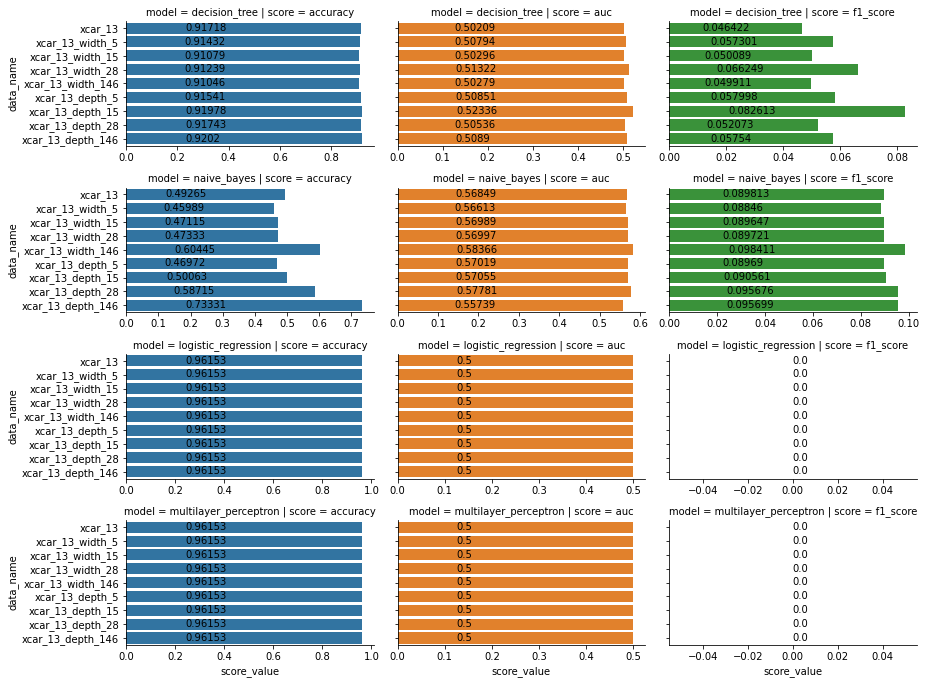

In [49]:
_ = showEvaluations(binning_evals)

### Best Binning Method

- Decision Tree
    - depth_15 (log2), width_28 (cbrt)
- Naive Bayes
    - width_146 (sqrt), depth_28 (cbrt), dept_146 (sqrt)
- Logit
    - zero result
- MLP
    - zero result


**Method Decision for the Final Classification**

There are two things I took from this.

1. The impact is not universal, the solution should be based on (and tried with) the specific classifier.

2. The impact is not very high. For the final classification solution I chose the binning approach with equal depth and log2 number of bins (depth_15). It made the most significant improvement for the Decision Tree (even though it was from 0.046 to 0.08) and that is the reason why I chose it.

# Save Models

- MemoryError (is what I have got)

```py
---------------------------------------------------------------------------
MemoryError                               Traceback (most recent call last)
<ipython-input-49-6c3818c13f56> in <module>
      1 if True: # SAVE MODELS
      2     for model in trained_models:
----> 3         pickle.dump(model, open(f"binning_{model[0].name}.pkl", "wb"))

MemoryError:
```

In [50]:
if False: # SAVE MODELS
    for model in binning_models:
        pickle.dump(model, open(f"binning_{model.classifier.name}_{model.train_set.name}.pkl", "wb"))

## Balancing

### Reference Set without Balancing

In [51]:
balancing = sample_thumb.copy(name="balancing")

In [52]:
print(f"Shape of the balancing dataframe: {balancing}\n")
print(f"Number of samples for every y class (y, size):", *balancing.get_train_y_groups_sizes(), sep="\n- ")

Shape of the balancing dataframe: <Data: name=balancing, train=(X.shape=(47617, 69), y.shape=(47617,)), test=(X.shape=(11905, 69), y.shape=(11905,))>

Number of samples for every y class (y, size):
- (0, 45893)
- (1, 1724)


### Under-sampling methods

- Random Under-sampling
- One-sided Selection
- Tomek links

**Note: balancing times with full set**
- One Sided Selection 
    - CPU total: 6h 47min 28s, Wall time: 6h 47min 29s
- Tomek Links
    - CPU total: 6h 10min 40s, Wall time: 6h 10min 40s

In [53]:
np.random.seed(seed=SEED)

balancers_under = (
    Balancer(name="random_under_sampling", method=RandomUnderSampler(random_state=SEED)),
    Balancer(name="one_sided_selection", method=OneSidedSelection(random_state=SEED)),
    Balancer(name="tomek_links", method=TomekLinks()),
)

### Over-sampling methods

- Random Over-sampling
- SMOTE

In [54]:
balancers_over = (
    Balancer(name="random_over_sampling", method=RandomOverSampler(random_state=SEED)),
    Balancer(name="smote", method=SMOTE(random_state=SEED))
)

### Over and Under Sampling Combination

- Smote + Tomek links

In [55]:
balancers_combi = (
    Balancer(name="smote_tomek", method=SMOTETomek(random_state=SEED)),
)

### Perform the Training Set Balancing

In [56]:
%%time

balanced_data = [balancing]

for balancers in (balancers_under, balancers_over, balancers_combi):
    for balancer in balancers:
        print("\n", f" {balancer.name} ".center(79, "-"))
        %time balanced_data.append(Data(name=balancer.name, train=Dataset(*balancer.method.fit_sample(balancing.train.X, balancing.train.y)), test=Dataset(*balancer.method.fit_sample(balancing.test.X, balancing.test.y))))

del balancers, balancer; print(f"\n{' Total cell execution time '.center(79, '#')}\n")


 ---------------------------- random_under_sampling ----------------------------
CPU times: user 71.6 ms, sys: 4.11 ms, total: 75.7 ms
Wall time: 75.2 ms

 ----------------------------- one_sided_selection -----------------------------
CPU times: user 3min 24s, sys: 0 ns, total: 3min 24s
Wall time: 3min 24s

 --------------------------------- tomek_links ---------------------------------
CPU times: user 2min 51s, sys: 0 ns, total: 2min 51s
Wall time: 2min 51s

 ----------------------------- random_over_sampling ----------------------------
CPU times: user 170 ms, sys: 0 ns, total: 170 ms
Wall time: 170 ms

 ------------------------------------ smote ------------------------------------
CPU times: user 497 ms, sys: 17.1 ms, total: 515 ms
Wall time: 514 ms

 --------------------------------- smote_tomek ---------------------------------
CPU times: user 4min 37s, sys: 0 ns, total: 4min 37s
Wall time: 4min 37s

########################## Total cell execution time #########################

### Train the Classifiers with Balanced Sets

In [57]:
%%time

balanced_models = []

for classifier in CLASSIFIERS:
    print("\n", f" {classifier.name} ".center(79, "-"), sep="")
    for data in balanced_data:
        %time balanced_models.append(trainModel(classifier, data))
        
del classifier, data; print(f"\n{' Total cell execution time '.center(79, '#')}\n")


-------------------------------- decision_tree --------------------------------

[decision_tree] balancing
CPU times: user 1.05 s, sys: 0 ns, total: 1.05 s
Wall time: 1.04 s

[decision_tree] random_under_sampling
CPU times: user 54.9 ms, sys: 0 ns, total: 54.9 ms
Wall time: 54.8 ms

[decision_tree] one_sided_selection
CPU times: user 1.12 s, sys: 0 ns, total: 1.12 s
Wall time: 1.11 s

[decision_tree] tomek_links
CPU times: user 1.05 s, sys: 0 ns, total: 1.05 s
Wall time: 1.05 s

[decision_tree] random_over_sampling
CPU times: user 1.58 s, sys: 0 ns, total: 1.58 s
Wall time: 1.58 s

[decision_tree] smote
CPU times: user 2.29 s, sys: 0 ns, total: 2.29 s
Wall time: 2.29 s

[decision_tree] smote_tomek
CPU times: user 2.3 s, sys: 0 ns, total: 2.3 s
Wall time: 2.3 s

--------------------------------- naive_bayes ---------------------------------

[naive_bayes] balancing
CPU times: user 51.4 ms, sys: 0 ns, total: 51.4 ms
Wall time: 50.9 ms

[naive_bayes] random_under_sampling
CPU times: user

/home/langerjaros/.langerenv_0.2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 1min 27s, sys: 1min 10s, total: 2min 37s
Wall time: 20 s

[logistic_regression] random_over_sampling
CPU times: user 2min 48s, sys: 2min 14s, total: 5min 2s
Wall time: 38.3 s

[logistic_regression] smote


/home/langerjaros/.langerenv_0.2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 2min 43s, sys: 2min 4s, total: 4min 48s
Wall time: 36.5 s

[logistic_regression] smote_tomek


/home/langerjaros/.langerenv_0.2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 2min 41s, sys: 2min 3s, total: 4min 45s
Wall time: 36.1 s

---------------------------- multilayer_perceptron ----------------------------

[multilayer_perceptron] balancing
CPU times: user 1min 28s, sys: 2min 13s, total: 3min 41s
Wall time: 28 s

[multilayer_perceptron] random_under_sampling
CPU times: user 36.8 s, sys: 55.5 s, total: 1min 32s
Wall time: 11.7 s

[multilayer_perceptron] one_sided_selection
CPU times: user 1min 24s, sys: 2min 11s, total: 3min 36s
Wall time: 27.8 s

[multilayer_perceptron] tomek_links
CPU times: user 2min 2s, sys: 3min 1s, total: 5min 4s
Wall time: 38.4 s

[multilayer_perceptron] random_over_sampling
CPU times: user 6min 29s, sys: 9min 25s, total: 15min 55s
Wall time: 2min

[multilayer_perceptron] smote
CPU times: user 3min 40s, sys: 5min 22s, total: 9min 2s
Wall time: 1min 8s

[multilayer_perceptron] smote_tomek
CPU times: user 3min 40s, sys: 5min 26s, total: 9min 7s
Wall time: 1min 9s

########################## Total cell execution tim

### Evaluate Balancing Methods

In [58]:
balancing_evals = []

for model in balanced_models:
    balancing_evals.append(evaluateModel(model))

[decision_tree]          balancing                Acc: 0.91718	AUC: 0.50209	F1: 0.04642
[decision_tree]          random_under_sampling    Acc: 0.47598	AUC: 0.47598	F1: 0.46785
[decision_tree]          one_sided_selection      Acc: 0.91691	AUC: 0.51787	F1: 0.07386
[decision_tree]          tomek_links              Acc: 0.91666	AUC: 0.51564	F1: 0.07014
[decision_tree]          random_over_sampling     Acc: 0.50389	AUC: 0.50389	F1: 0.08181
[decision_tree]          smote                    Acc: 0.90797	AUC: 0.90797	F1: 0.90524
[decision_tree]          smote_tomek              Acc: 0.90797	AUC: 0.90797	F1: 0.90524
[naive_bayes]            balancing                Acc: 0.49265	AUC: 0.56849	F1: 0.08981
[naive_bayes]            random_under_sampling    Acc: 0.51856	AUC: 0.51856	F1: 0.15355
[naive_bayes]            one_sided_selection      Acc: 0.48203	AUC: 0.57026	F1: 0.09095
[naive_bayes]            tomek_links              Acc: 0.48288	AUC: 0.57070	F1: 0.09109
[naive_bayes]            random_

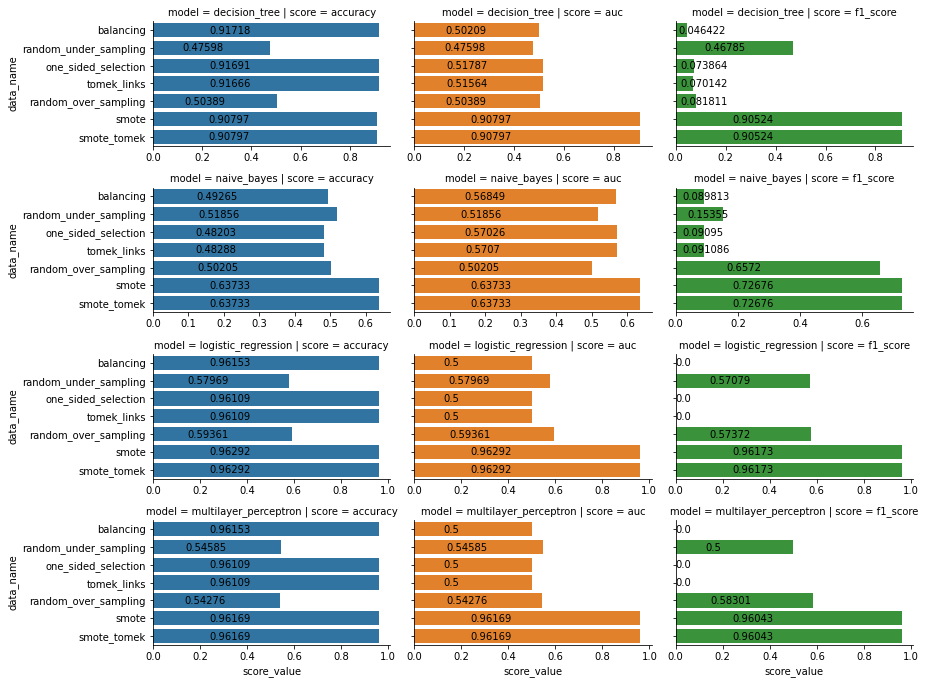

In [59]:
_ = showEvaluations(balancing_evals)

### Balancing Results

Accuracy

- The only balancing methods that made better results than the unbalanced data were the SMOTE and SMOTE-Tomek (both have the highes accuracy with Naive Bayes, Logit and MLP).
- One-sided selection and Tomek links have similar accuracies as the unbalanced data.

AOC (Balanced Accuracy)

- The only balancing methods that stood out was again the SMOTE and SMOTE-Tomek, all the other made basicaly no difference.

F1-Score

- Besides the SMOTE and SMOTE-Tomek the Random Over and Under sampling improved some prediction.

**Decesion for the final classifications**

- Because the success of SMOTE-Tomek looks more like success of SMOTE, I choose SMOTE as one balancing method to the final round.
- As the accuracy of the original data was always high, the attention would be at increasing the AOC and F1 score. From random over and under sampling the over-sampling looks a bit better, however I chosed the under-sampling for the final classification to represent the winners of both the over-sampling and under-sampling.

## Classification Tests and Evalutaions

- Applying the thumb rules plus the binning winner.

In [90]:
def dataCleansing(data, binning_feature):
    """Perform basic data cleansing.
    Namely: drop half empty features, drop high-cardinality features, 
    convert type of categorical featrues, perform one-hot encoding,
    and binning for specified feature"""
    data = dropHalfEmptyColumns(data) # Rule of thumb
    data = dropHighCardinalityCategoricalFeatures(data) # Rule of thumb
    data = convertCategoricalFeatures(data) # Must
    data = oneHotEncoding(data) # Must
    data = dropMissingValuesEncodedToFeatures(data) # Rule of thumb
    # Binning
    binned_feature = discretizeFeature(binning_feature, data, equal="depth", interval_method=np.log2) # Best for DT
    data = data.drop_features([binning_feature]) # Drop original feature
    return data 

### Copy the original dataframe and perform data cleansing separately on train and test sets

In [91]:
unbalanced = dataCleansing(original.copy(), "xcar_13")

Train - categorical columns types: [<class 'pandas.core.dtypes.dtypes.CategoricalDtype'>]
Train - other columns types:       [dtype('int64') dtype('float64')]

Test - categorical columns types: [<class 'pandas.core.dtypes.dtypes.CategoricalDtype'>]
Test - other columns types:       [dtype('int64') dtype('float64')]

Number of Intervals: 16
Name of binned feature: xcar_13_depth_16


### Create Under-sampled Data with Random Under-sampling method

In [94]:
%%time

balancer = Balancer(name="random_under_sampling", method=RandomUnderSampler(random_state=SEED))

under_sampled = Data(
    name=balancer.name, 
    train=Dataset(*balancer.method.fit_sample(unbalanced.train.X, unbalanced.train.y)),
    test=Dataset(*balancer.method.fit_sample(unbalanced.test.X, unbalanced.test.y))
)

CPU times: user 277 ms, sys: 23.7 ms, total: 301 ms
Wall time: 314 ms


### Create Over-sampled Data by Performing SMOTE method

In [99]:
%%time

balancer = Balancer(name="smote", method=SMOTE(random_state=SEED))

over_sampled = Data(
    name=balancer.name, 
    train=Dataset(*balancer.method.fit_sample(unbalanced.train.X, unbalanced.train.y)),
    test=Dataset(*balancer.method.fit_sample(unbalanced.test.X, unbalanced.test.y))
)

CPU times: user 33.7 s, sys: 1.27 s, total: 35 s
Wall time: 36.6 s


### See the Target Variable Sizes of Either the Original, Under-sampled and Over-sampled Data

In [106]:
print(f"Unbalanced class sizes:    {unbalanced.get_train_y_groups_sizes()}",
      f"Under-sampled class sizes: {under_sampled.get_train_y_groups_sizes()}",
      f"Over-sampled class sizes:  {over_sampled.get_train_y_groups_sizes()}",
sep="\n")

Unbalanced class sizes:    [(0, 458893), (1, 17276)]
Under-sampled class sizes: [(1, 17276), (0, 17276)]
Over-sampled class sizes:  [(1, 458893), (0, 458893)]


### Train the Classifiers

In [101]:
%%time

trained_models = []

for classifier in CLASSIFIERS:
    print("\n", f" {classifier.name} ".center(79, "-"), sep="")

    for data in (unbalanced, under_sampled, over_sampled):
        %time trained_models.append(trainModel(classifier, data))
        
del classifier, data; print(f"\n{' Total cell execution time '.center(79, '#')}\n")


-------------------------------- decision_tree --------------------------------

[decision_tree] original_copy
CPU times: user 12.6 s, sys: 18.5 ms, total: 12.6 s
Wall time: 12.6 s

[decision_tree] random_under_sampling
CPU times: user 504 ms, sys: 739 µs, total: 505 ms
Wall time: 504 ms

[decision_tree] smote
CPU times: user 20.4 s, sys: 25.6 ms, total: 20.4 s
Wall time: 20.4 s

--------------------------------- naive_bayes ---------------------------------

[naive_bayes] original_copy
CPU times: user 842 ms, sys: 125 ms, total: 968 ms
Wall time: 970 ms

[naive_bayes] random_under_sampling
CPU times: user 68.5 ms, sys: 1.39 ms, total: 69.9 ms
Wall time: 69.2 ms

[naive_bayes] smote
CPU times: user 1.08 s, sys: 224 ms, total: 1.31 s
Wall time: 1.31 s

----------------------------- logistic_regression -----------------------------

[logistic_regression] original_copy
CPU times: user 12min 3s, sys: 8min 30s, total: 20min 33s
Wall time: 2min 41s

[logistic_regression] random_under_sampli

/home/langerjaros/.langerenv_0.2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 27min 56s, sys: 16min 33s, total: 44min 29s
Wall time: 5min 58s

---------------------------- multilayer_perceptron ----------------------------

[multilayer_perceptron] original_copy
CPU times: user 9min 52s, sys: 15min 10s, total: 25min 3s
Wall time: 3min 19s

[multilayer_perceptron] random_under_sampling
CPU times: user 1min 42s, sys: 2min 36s, total: 4min 19s
Wall time: 32.9 s

[multilayer_perceptron] smote
CPU times: user 46min 15s, sys: 1h 14min 18s, total: 2h 34s
Wall time: 16min 1s

########################## Total cell execution time ##########################

CPU times: user 1h 39min 20s, sys: 1h 57min 59s, total: 3h 37min 20s
Wall time: 29min 23s


### Evaluate the Models and Visualize the Evaluations

In [102]:
evaluations = []

for model in trained_models:
    evaluations.append(evaluateModel(model))

[decision_tree]          original_copy            Acc: 0.91683	AUC: 0.50622	F1: 0.05299
[decision_tree]          random_under_sampling    Acc: 0.53384	AUC: 0.53384	F1: 0.53735
[decision_tree]          smote                    Acc: 0.92583	AUC: 0.92583	F1: 0.92460
[naive_bayes]            original_copy            Acc: 0.86298	AUC: 0.53680	F1: 0.09085
[naive_bayes]            random_under_sampling    Acc: 0.55998	AUC: 0.55998	F1: 0.43570
[naive_bayes]            smote                    Acc: 0.64509	AUC: 0.64509	F1: 0.73017
[logistic_regression]    original_copy            Acc: 0.96289	AUC: 0.50000	F1: 0.00000
[logistic_regression]    random_under_sampling    Acc: 0.59178	AUC: 0.59178	F1: 0.57916
[logistic_regression]    smote                    Acc: 0.95969	AUC: 0.95969	F1: 0.95840
[multilayer_perceptron]  original_copy            Acc: 0.96289	AUC: 0.50000	F1: 0.00000
[multilayer_perceptron]  random_under_sampling    Acc: 0.59631	AUC: 0.59631	F1: 0.59480
[multilayer_perceptron]  smote  

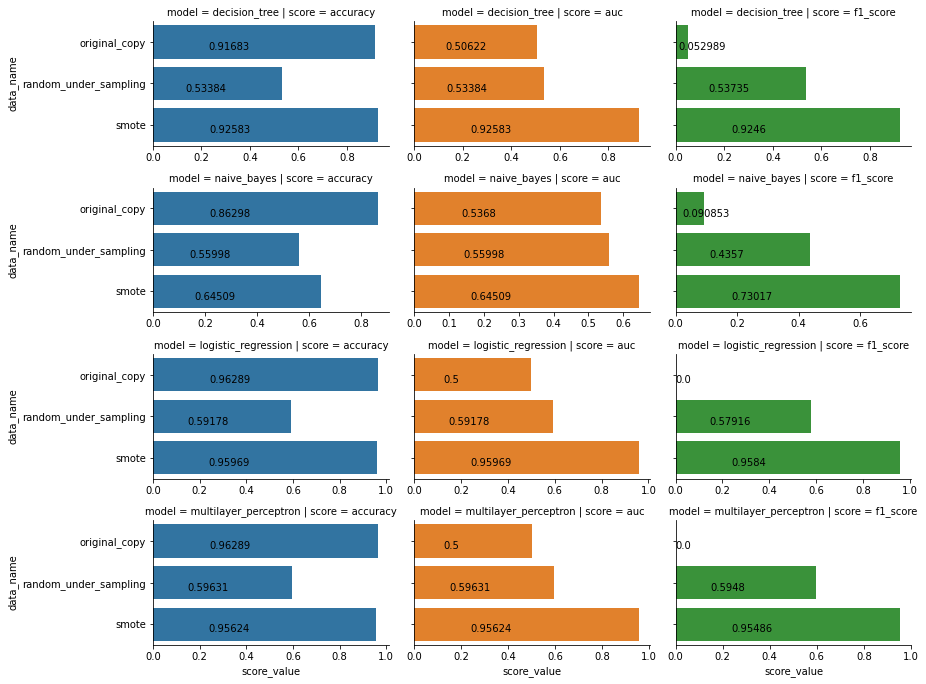

In [103]:
_ = showEvaluations(evaluations)

### Conclusion

- Balancing improved the models predictions very much.
- The SMOTE has the highest score for every model at AUC and F1-score metrics. The accuracy is similar to the original only the accuracy of Naive Bayes dropped significantly.
- Random undersampling improved every single score of AUC and F1-score metrics in comparison to the unbalanced data. However the accuracy dropped every single time (could be harmful if we would want to maximaze the accuracy).

- The final scores of every metric looks good to me. Of course it depends what was the goal to achieve, however when comparing it to the unbalanced data I am positively supprised how much tha balancing helped. 
- In fact the balancing probably mettered more than the classifer selection and binning approach, that is impressive.